In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import json
import time

In [2]:
df = pd.read_excel('xupeng-3版本.xlsx')
df = df.dropna()

def get_xy(row):
    lon, lat = row[5], row[4]
    return m(lon, lat)

def deal_conc(row):
    cont = row[2]
    conc = float(cont[:-5].replace(',', ''))
    unit = cont[-4:].replace('/km2', 'n/km2')
    return conc, unit

In [3]:
df['conc'], df['unit'] = df.apply(deal_conc, axis=1).str

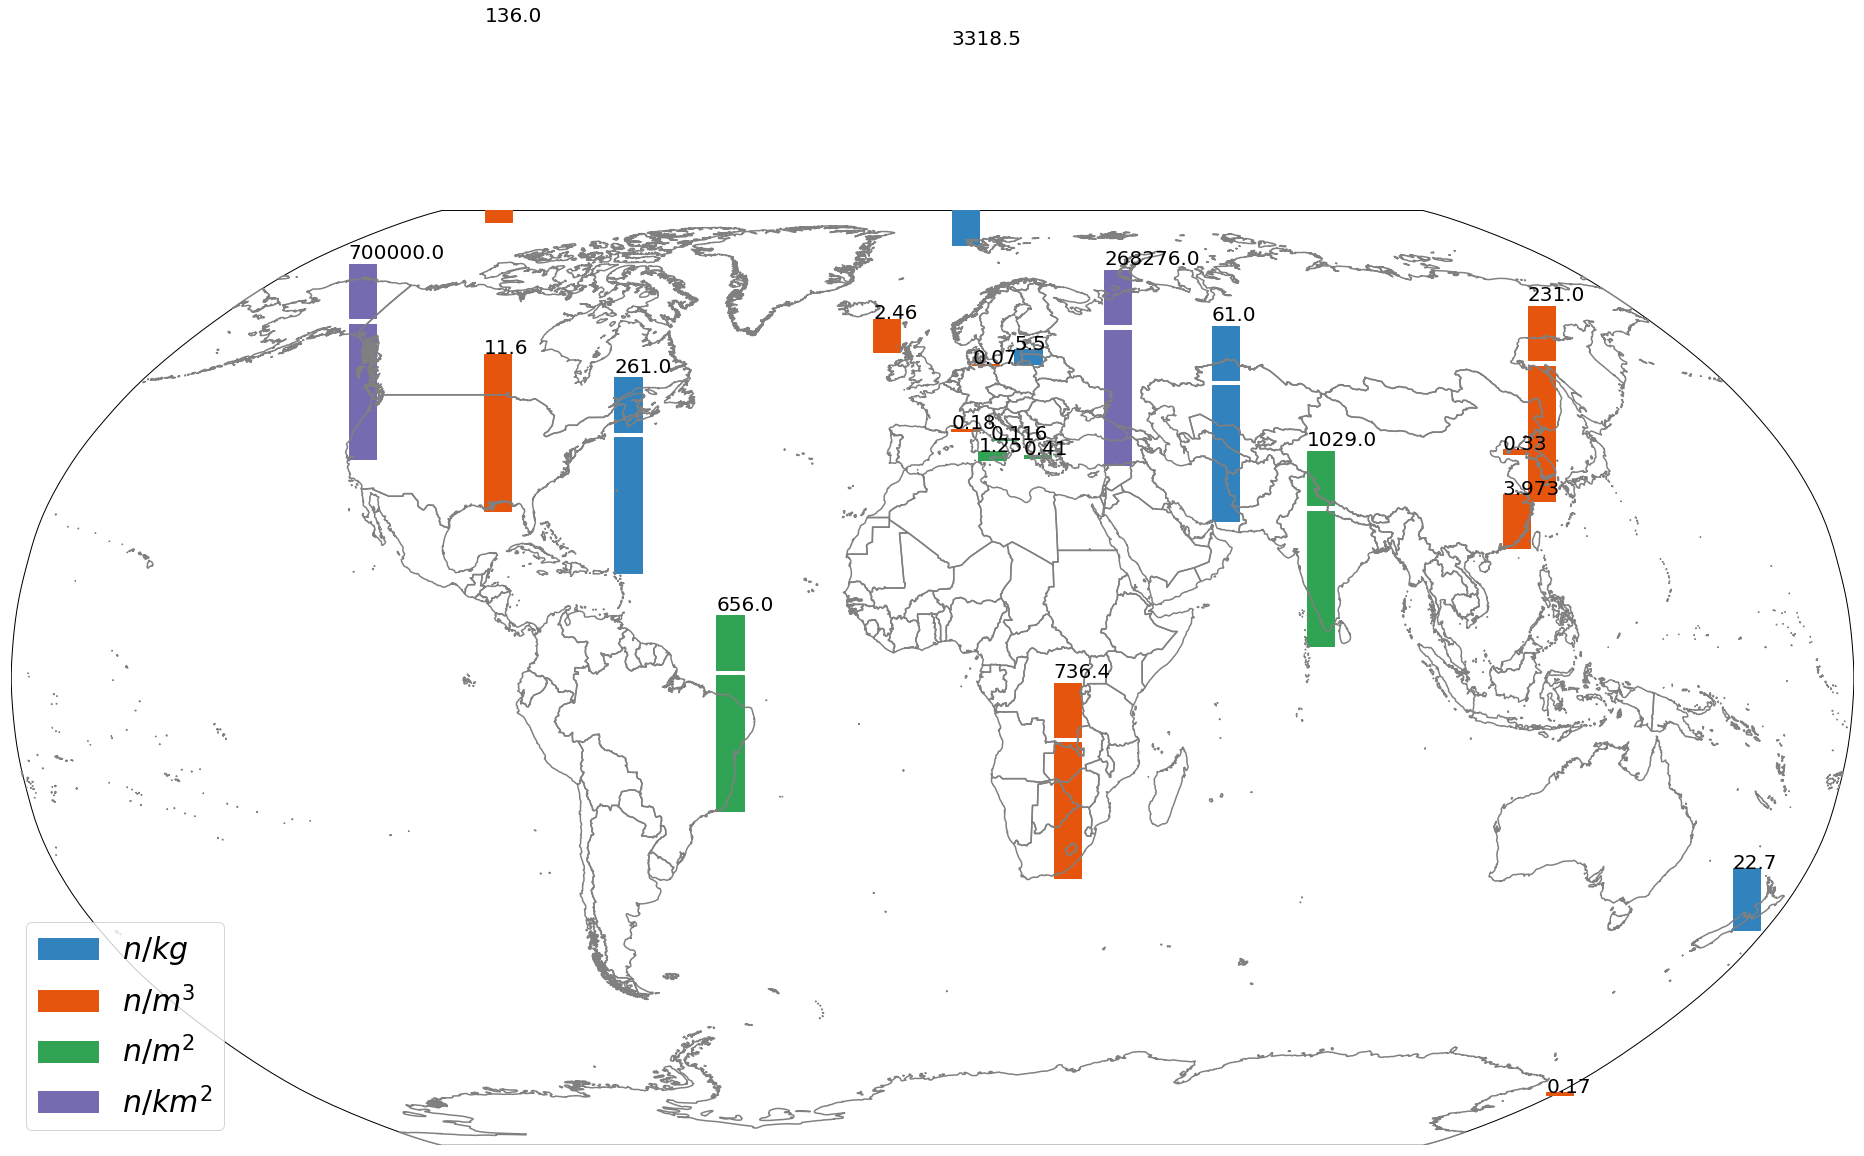

In [4]:
fig = plt.figure(figsize=(32, 18))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(projection='robin', lon_0=0, resolution='l',ax=ax)
shp_info =m.readshapefile('world_shape/TM_WORLD_BORDERS', 'scalerank', drawbounds=False)
#m.fillcontinents(color='gray',lake_color='white')
#m.drawcoastlines()
m.drawcoastlines(color='white', zorder=0)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.drawmapboundary(fill_color='white', linewidth=0)

xy = df.apply(get_xy, axis=1).str
df['x'], df['y'] = xy
for info, shp in zip(m.scalerank_info, m.scalerank):
    poly = Polygon(shp, facecolor='white', edgecolor='w', alpha=1)
    line_x, line_y = list(zip(*shp))
    line = Line2D(line_x, line_y, c='grey',alpha=1)
    ax.add_patch(poly)
    ax.add_line(line)

units = df['unit'].unique()
units_ = ['$n/kg$', '$n/m^3$', '$n/m^2$', '$n/km^2$']
weights = [1000, 5000, 2500, 1]
cmap = plt.get_cmap("tab20c")
colors = cmap(np.arange(4)*4)
for i, unit in enumerate(units):
    data = df[df['unit'] == unit]
    pivot = True
    unit = units_[i]
    for row in data.iterrows():
        cont = row[1]
        y = cont[-1]
        x = cont[-2]
        #unit = cont[-3]
        conc = cont[-4]
        height = conc*weights[i]*50
        
        if height < 3e6:            
            if pivot:
                rect = Rectangle((x, y), width=500000, height=conc*weights[i]*50, color=colors[i], label = unit)
                pivot = False
            else:
                rect = Rectangle((x, y), width=500000, height=conc*weights[i]*50, color=colors[i])           

            ax.add_patch(rect)
            ax.text(x, y+height, conc, fontsize=20)
            
        else:
            if pivot:
                rect1 = Rectangle((x, y), width=500000, height=2.5e6, color=colors[i], label = unit)
                rect2 = Rectangle((x, y+2.6e6), width=500000, height=1e6, color=colors[i])
                pivot = False
            else:
                rect1 = Rectangle((x, y), width=500000, height=2.5e6, color=colors[i])
                rect2 = Rectangle((x, y+2.6e6), width=500000, height=1e6, color=colors[i])
                
            ax.add_patch(rect1)
            ax.add_patch(rect2)
            ax.text(x, y+3.7e6, conc, fontsize=20)
            
        #ax.text(x, y-4e5, cont[1], fontsize=20)
        
ax.legend(fontsize=30)
plt.show()
fig.savefig('xupeng.png')